# TODO: This ML engineer notebook should be running in its own separate container

In [1]:
# !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz
import os 
import json

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from snowflake.snowpark import Session

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/envs/rapids/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:46: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


## Connect to Snowflake / Snowpark Session

In [2]:
#Very easy to connect to your snowflake account

def get_token():
    with open('/snowflake/session/token', 'r') as f:
        return f.read()

connection_params = {
    'host': os.environ['SNOWFLAKE_HOST'],
    'port': os.environ['SNOWFLAKE_PORT'],
    'protocol': 'https',
    'account': os.environ['SNOWFLAKE_ACCOUNT'],
    'authenticator': 'oauth',
    'token': get_token(),
    'role': 'SERVICESNOW_USER_ROLE',
    'warehouse': 'MADKINS',
    'database': 'TOPIC_MODELING',
    'schema': 'PROD'
}

session = Session.builder.configs(connection_params).create()
session

In [3]:
session.get_current_warehouse(), session.get_current_role(), session.get_current_database(), session.get_current_schema()

('"MADKINS"', '"SERVICESNOW_USER_ROLE"', '"TOPIC_MODELING"', '"PROD"')

## Visualize our data

In [4]:
query = '''

    SELECT
        *
    FROM
        MUSIC_STORE_REVIEWS
    LIMIT 5
    
'''
df = session.sql(query).to_pandas()
df.head()

,DATE,PRODUCT,REVIEW,RATING
0,2023-06-01,Harmony G10 Electric Guitar,I am amazed by the sound quality of this guita...,5
1,2023-05-29,Melody M5000 Grand Piano,"The keys on this piano feel a bit stiff, but t...",3
2,2023-05-25,Rhythm R200 Drum Set,"I've been playing drums for years, and this dr...",5
3,2023-05-20,Serenade S700 Acoustic Guitar,I'm not impressed with this guitar. The tone i...,2
4,2023-05-18,Cadence C1500 Keyboard,This keyboard is great for beginners. It has a...,3


## Load our NLP model

In [6]:
#Pre-run this guy
model_gpu = SentenceTransformer('all-mpnet-base-v2', device='cuda')
model_cpu = SentenceTransformer('all-mpnet-base-v2', device="cpu")

<AxesSubplot: >

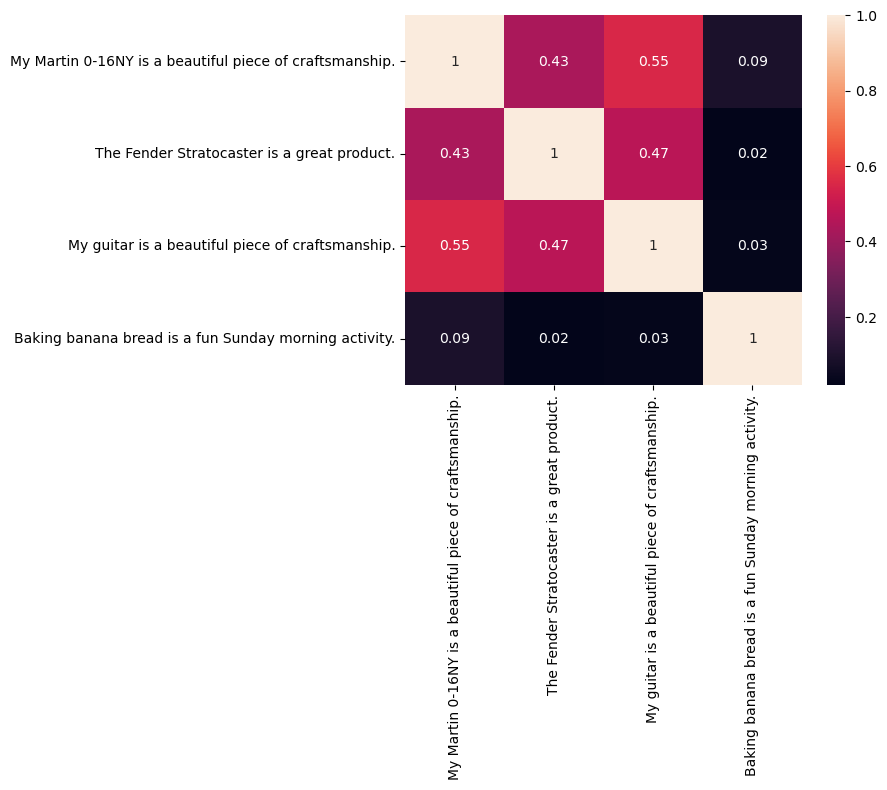

In [7]:
sentences = [
    "My Martin 0-16NY is a beautiful piece of craftsmanship.",
    "The Fender Stratocaster is a great product.",
    "My guitar is a beautiful piece of craftsmanship.",
    "Baking banana bread is a fun Sunday morning activity."
]

embeddings = model_gpu.encode(sentences)
similarities = cosine_similarity(embeddings).round(2)

similarities_df = pd.DataFrame(similarities)
similarities_df.columns = sentences
similarities_df.index = sentences

sns.heatmap(similarities_df, annot=True)

The embeddings from the baseline model suggest that these sentences are only somewhat similar, as the cosine similarity of just a bit over 0.5. In fact, we'd probably like for our model to think that all of the first three sentences are quite similar, as they all refer to guitars being of high quality. Fine-tuning on data relevant to our use case can help us improve the results.

Below, we fine-tune our model with a few examples to help it learn that a Martin-016NY is a type of guitar and that Fender is a guitar brand. We assign loose similarity scores as the `label` field to help teach the model which sentences are similar and which are dissimilar.

## Setting up the Training Data

In [9]:
# We'd use more examples in the real-world scenario.
train_examples = [
    InputExample(
        texts=["My Martin 0-16NY is a beautiful piece of craftsmanship.", "My guitar is a beautiful piece of craftsmanship."], label=0.95
    ),
    InputExample(
        texts=["My Martin 0-16NY is a beautiful piece of craftsmanship.", "James walked quickly through the forest."], label=0.1
    ),
    InputExample(
        texts=["When I played with a Martin 0-16NY every chord sounded perfect", "Sarah played her favorite songs on her guitar"], label=0.8
    ),
    InputExample(
        texts=["Fender has been making guitars for decades.", "Guitar-making has a rich history spanning decades."], label=0.8
    ),
    InputExample(
        texts=["Baking is a great way to relax.", "Guitar is an important instrument for rock and roll bands"], label=0.1
    ),
]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model_cpu)

Let's fine-tune using the CPU-based model first, to get a sense of speed.

In [10]:
%%time

model_cpu = SentenceTransformer('all-mpnet-base-v2', device="cpu")
train_loss = losses.CosineSimilarityLoss(model_cpu)
model_cpu.fit(train_objectives=[(train_dataloader, train_loss)], epochs=15, warmup_steps=100)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 4min 46s, sys: 5.16 s, total: 4min 51s
Wall time: 13.8 s


That took about 10-15 seconds. Let's see how long it takes when we use an NVIIDA GPU.

In [11]:
%%time

model_gpu = SentenceTransformer('all-mpnet-base-v2', device='cuda')
train_loss = losses.CosineSimilarityLoss(model_gpu)
model_gpu.fit(train_objectives=[(train_dataloader, train_loss)], epochs=15, warmup_steps=100)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2.55 s, sys: 287 ms, total: 2.84 s
Wall time: 1.85 s


Much faster.

Let's see how our fine-tuning changed the embeddings generated by the model.

<AxesSubplot: title={'center': 'Similarity Scores from the Fine-Tuned Model'}>

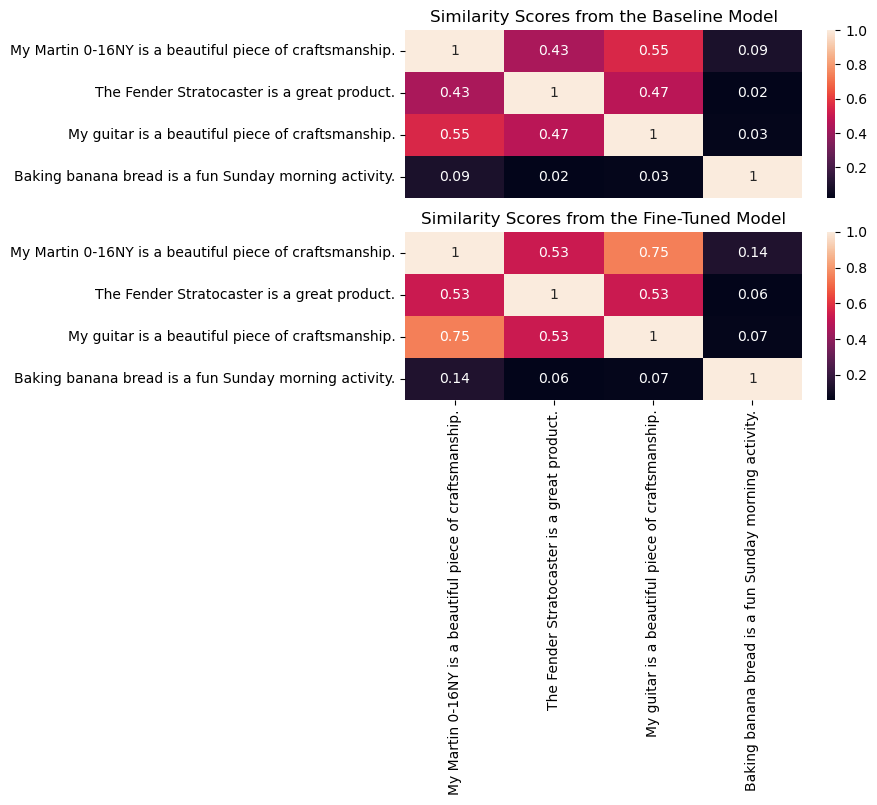

In [12]:
new_embeddings = model_gpu.encode(sentences)
new_similarities = cosine_similarity(new_embeddings).round(2)

new_similarities_df = pd.DataFrame(new_similarities)
new_similarities_df.columns = sentences
new_similarities_df.index = sentences

fig, axes = plt.subplots(2, 1)

axes[0].set_title("Similarity Scores from the Baseline Model")
axes[1].set_title("Similarity Scores from the Fine-Tuned Model")
sns.heatmap(similarities_df, annot=True, ax=axes[0], xticklabels="")
sns.heatmap(new_similarities_df, annot=True, ax=axes[1])

# Snowpark Containers Job
We kick off a job to do this at scale and save the model to a stage

In [13]:
query = '''

    SHOW COMPUTE POOLS LIKE 'NVIDIA_A10Gx4';
    
'''

pd.DataFrame(session.sql(query).collect())

,name,state,min_nodes,max_nodes,instance_family,num_services,auto_suspend_secs,auto_resume,active_nodes,idle_nodes,created_on,resumed_on,updated_on,owner,comment
0,NVIDIA_A10GX4,ACTIVE,1,1,GPU_7,1,0,true,1,0,2023-06-07 17:47:16.740000-07:00,2023-06-08 08:25:21.057000-07:00,2023-06-08 08:43:42.457000-07:00,SERVICESNOW_USER_ROLE,None


In [14]:
query = '''

    EXECUTE SERVICE WITH
        COMPUTE_POOL = NVIDIA_A10Gx4
        SPEC = @tm_stage/transformers_train_manifest.yaml;

'''

session.sql(query).collect()

[Row(status='Execution submitted successfully as 01acd543-0001-a5ae-001f-900700435296.')]

In [17]:
query = '''

    CALL SYSTEM$GET_JOB_LOGS('01acd543-0001-a5ae-001f-900700435296', 'nvidia-train',1000);

'''

session.sql(query).collect()

# Creating Embeddings from Reviews

We want our data science teams to be able to analyze our product reviews and identify business insights. To help them, we can create a new table in Snowflake that stores neural network embeddings of all of our reviews.

In [189]:
# For the live demo, we'll limit to 20K reviews for the sake of time.

query = '''

    SELECT
        *
    FROM
        MUSIC_STORE_REVIEWS
    LIMIT 20000
    
'''
music_reviews_df = session.sql(query).to_pandas()
music_reviews_df.head()

,DATE,PRODUCT,REVIEW,RATING
0,2023-06-01,Harmony G10 Electric Guitar,I am amazed by the sound quality of this guita...,5
1,2023-05-29,Melody M5000 Grand Piano,"The keys on this piano feel a bit stiff, but t...",3
2,2023-05-25,Rhythm R200 Drum Set,"I've been playing drums for years, and this dr...",5
3,2023-05-20,Serenade S700 Acoustic Guitar,I'm not impressed with this guitar. The tone i...,2
4,2023-05-18,Cadence C1500 Keyboard,This keyboard is great for beginners. It has a...,3


In [190]:
session.sql("drop table MUSIC_STORE_REVIEWS_DEMO_SAMPLE").collect()

[Row(status='MUSIC_STORE_REVIEWS_DEMO_SAMPLE successfully dropped.')]

In [191]:
session.write_pandas(
    df=music_reviews_df,
    table_name="MUSIC_STORE_REVIEWS_DEMO_SAMPLE",
    auto_create_table=True,
)

In [192]:
saved_model = SentenceTransformer(
    "/rapids/notebooks/tm_stage/topic-modeling/fine-tuned-model/"
)

In [195]:
docs = music_reviews_df.REVIEW.tolist()

embeddings = saved_model.encode(
    sentences=docs,
    batch_size=64,
    show_progress_bar=True
)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [197]:
embeddings.shape

(20000, 768)

In [198]:
embeddings_df_str = pd.DataFrame(embeddings).astype("str")
embeddings_df_final = pd.DataFrame({"embeddings": embeddings_df_str.values.tolist()})
embeddings_df_final.head()

,embeddings
0,"[-0.040691473, 0.050299656, 0.028347412, 0.043..."
1,"[0.026098829, 0.001783191, 0.036855936, 0.0290..."
2,"[-0.029661525, 0.0006159523, 0.009432108, 0.03..."
3,"[-0.0025900165, -0.0018359589, 0.021670623, 0...."
4,"[0.024640746, -0.058263652, 0.04633961, 0.0256..."


In [203]:
session.write_pandas(
    df=embeddings_df_final,
    table_name="MUSIC_STORE_REVIEW_EMBEDDINGS_DEMO_SAMPLE",
    auto_create_table=True,
)   

# What about new reviews in real-time?

We really need a service to do this Deep Learning model inference as reviews come in so our data scientists can always have the most updated data for analysis.

### Serving our Model with Triton Inference Server

Let's launch a Snowpark Containers **Service** that and create a **Services Function** to deploy and use our model with NVIDIA's Triton Inference Server. Triton lets us etc. etc.

In [ ]:
query = '''
    
    CREATE SERVICE topic_modeling
        MIN_INSTANCES = 1
        MAX_INSTANCES = 1
        COMPUTE_POOL = NVIDIA_A10Gx4
        SPEC = '@tm_stage/manifest.yaml';

'''
session.sql(query).collect()

In the real-world, reviews are coming in and are collected into our reviews table which is sorted date.

We can create a **Services Function** to handle this exact scenario.

With our Services Function, we can process the brand new reviews and insert them into our newly created embeddings table so our data scientists can use them when they do their analysis.

We'll simulate a batch of brand new reviews coming into our demo table.

In [208]:
fresh_reviews = """
{"Product": "StrumMaster S1200 Acoustic Guitar", "Review": "The StrumMaster S1200 is an outstanding acoustic guitar with a rich and resonant tone. The craftsmanship is exceptional, and it's a joy to play. Highly recommended for both beginners and professionals!", "Rating": 5, "Date": "2023-06-26 12:43:21"}
{"Product": "BeatBox B1200 Electronic Drum Kit", "Review": "The BeatBox B1200 is a versatile electronic drum kit with a wide range of sounds and responsive pads. The build quality is solid, and it offers extensive customization options. A great choice for drummers of all levels.", "Rating": 4, "Date": "2023-06-26 12:43:21"}
{"Product": "SonicKey S1200 Digital Keyboard", "Review": "The SonicKey S1200 is a reliable digital keyboard with good sound quality and a user-friendly interface. It offers a decent range of sounds and features, making it suitable for beginners and intermediate players.", "Rating": 3, "Date": "2023-06-26 12:43:28"}
{"Product": "Harmony H1200 Electric Guitar", "Review": "The Harmony H1200 is an exceptional electric guitar with a versatile tone and superb playability. The craftsmanship is top-notch, and it's a joy to play both on stage and in the studio. A top choice for serious guitarists.", "Rating": 5, "Date": "2023-06-26 12:43:32"}
{"Product": "RhythmMaster R1100 Drum Set", "Review": "The RhythmMaster R1100 is a professional-grade drum set with outstanding sound quality and durability. The hardware is solid, and it offers excellent resonance. Highly recommended for serious drummers!", "Rating": 5, "Date": "2023-06-26 12:44:20"}
{"Product": "Melodious M800 Violin", "Review": "The Melodious M800 is a decent violin with a warm and balanced tone. It's suitable for intermediate players looking to upgrade. However, the included bow could be of better quality.", "Rating": 3, "Date": "2023-06-26 12:44:41"}
{"Product": "Cadence C1600 Digital Piano", "Review": "The Cadence C1600 is a high-end digital piano that delivers exceptional sound quality and realistic touch. The keys feel incredibly close to an acoustic piano, and the range of voices and features is impressive. A top-notch instrument for professional pianists.", "Rating": 5, "Date": "2023-06-26 12:44:01"}
{"Product": "RockStar R800 Bass Guitar", "Review": "The RockStar R800 is a reliable bass guitar with a solid sound and comfortable playability. It's a suitable choice for beginners and intermediate bassists. Good value for the price.", "Rating": 4, "Date": "2023-06-26 12:44:21"}
{"Product": "Symphony S1800 Flute", "Review": "The Symphony S1800 is a professional-grade flute with a beautiful and expressive tone. The keys are smooth and responsive, and the craftsmanship is impeccable. A top-notch choice for serious flutists.", "Rating": 5, "Date": "2023-06-26 12:44:29"}
{"Product": "PianoPro P9000 Grand Piano", "Review": "The PianoPro P9000 is an exquisite grand piano with a rich and expressive sound. The craftsmanship is exceptional, and it's a statement piece for any musician or music lover. A true work of art!", "Rating": 5, "Date": "2023-06-26 12:44:53"}
"""

fresh_reviews = pd.read_json(fresh_reviews, lines=True)

# Match our current table's schema
fresh_reviews = fresh_reviews[["Date", "Product", "Review", "Rating"]]
fresh_reviews.columns = ["DATE", "PRODUCT", "REVIEW", "RATING"]
fresh_reviews["DATE"] = fresh_reviews["DATE"].astype("int64")

fresh_reviews.head()

,DATE,PRODUCT,REVIEW,RATING
0,1687783401000000000,StrumMaster S1200 Acoustic Guitar,The StrumMaster S1200 is an outstanding acoust...,5
1,1687783401000000000,BeatBox B1200 Electronic Drum Kit,The BeatBox B1200 is a versatile electronic dr...,4
2,1687783408000000000,SonicKey S1200 Digital Keyboard,The SonicKey S1200 is a reliable digital keybo...,3
3,1687783412000000000,Harmony H1200 Electric Guitar,The Harmony H1200 is an exceptional electric g...,5
4,1687783460000000000,RhythmMaster R1100 Drum Set,The RhythmMaster R1100 is a professional-grade...,5


In [209]:
# Insert these 10 fresh records into our table
session.write_pandas(
    df=fresh_reviews,
    table_name="MUSIC_STORE_REVIEWS_DEMO_SAMPLE",
)

In [221]:
# Create our services function

query = '''

    CREATE OR REPLACE FUNCTION triton(n VARCHAR)
      RETURNS ARRAY
      SERVICE = topic_modeling
      ENDPOINT = 'tritonclient'
      MAX_BATCH_ROWS = 1000
      AS '/inference_topic_modeling'

'''
session.sql(query).collect()

[Row(status='Function TRITON successfully created.')]

In [238]:
cutoff_time = fresh_reviews["DATE"].iloc[0]

query = f'''
    SELECT
        triton(REVIEW) as embeddings
    FROM
        "MUSIC_STORE_REVIEWS_DEMO_SAMPLE"
    WHERE
        DATE >= '{cutoff_time}'

'''
result = session.sql(query)
result.toPandas().shape

(10, 1)

In [239]:
result.write.mode("append").save_as_table("MUSIC_STORE_REVIEW_EMBEDDINGS_DEMO_SAMPLE")

In [240]:
query = '''
    SELECT
        COUNT(*)
    FROM
        MUSIC_STORE_REVIEW_EMBEDDINGS_DEMO_SAMPLE    
'''
session.sql(query).collect()

[Row(COUNT(*)=20010)]

# Confidently Bringing custom AI/ML Workflows to Production

Fine tuning models and serving ML models for inference are often part of important business processes. Using only open-source frameworks makes sense for testing and kicking the tires, but for production workloads we need to make sure our workloads are secure, well supported, and meeting any necessary SLAs.

NVIDIA AI Enterprise provides stable, secure branches, enterprise support, and other key considerations for moving workloads into production. With the new Snowflake-NVIDIA partnership announced at Snowflake Summit, your organization can purchase an NVIDIA AI Enterprise license on the Snowflake marketplace and smoothly deploy AI and ML models and workflows in the Snowflake platform.